LSTM


In [2]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import itertools

start_time = time.time()

# ─────────────────────── 1. Load & Preprocess Data ───────────────────────
df = pd.read_csv("/omni_dataset.csv")

FEATURES = ['sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
            'sw_plasma_temp_k', 'sw_proton_density_n_cm3']
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12

df = df[FEATURES + [TARGET]].dropna()
N = len(df)

N_train = int(0.8 * N)
N_val = int(0.1 * N)
N_test = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df = df.iloc[N_train:N_train + N_val]
test_df = df.iloc[N_train + N_val:]

# Scaling
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled = X_scaler.transform(val_df[FEATURES])
X_test_scaled = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled = y_scaler.transform(test_df[[TARGET]]).ravel()

def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val, y_val = make_windows(X_val_scaled, y_val_scaled, LOOK_BACK, HORIZON)
X_test, y_test = make_windows(X_test_scaled, y_test_scaled, LOOK_BACK, HORIZON)

# ─────────────── 2. Grid Search (Manual) for Hyperparameter Tuning ───────────────
param_grid = {
    'units': [32, 64],
    'batch_size': [16, 32],
    'epochs': [30],
}

best_model, best_params, best_val_loss = None, None, float('inf')

for units, batch_size, epochs in itertools.product(*param_grid.values()):
    model = Sequential([
        LSTM(units, input_shape=(LOOK_BACK, len(FEATURES))),
        Dense(HORIZON)
    ])
    model.compile(loss='mse', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_model = model
        best_val_loss = val_loss
        best_params = {
            'units': units,
            'batch_size': batch_size,
            'epochs': epochs
        }

print("\nBest Hyperparameters:", best_params)

# ───────────────────── 3. Predict & Compute Metrics ──────────────────────
y_min, y_max = y_scaler.data_min_[0], y_scaler.data_max_[0]
inv = lambda arr: arr * (y_max - y_min) + y_min

y_pred_train = inv(best_model.predict(X_train, verbose=0))
y_true_train = inv(y_train)

y_pred_val = inv(best_model.predict(X_val, verbose=0))
y_true_val = inv(y_val)

y_pred_test = inv(best_model.predict(X_test, verbose=0))
y_true_test = inv(y_test)

records = []
for split, yt, yp in [('Train', y_true_train, y_pred_train),
                      ('Val', y_true_val, y_pred_val),
                      ('Test', y_true_test, y_pred_test)]:
    for h in range(HORIZON):
        t_true, t_pred = yt[:, h], yp[:, h]
        mse = mean_squared_error(t_true, t_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(t_true, t_pred)
        mape = mean_absolute_percentage_error(t_true, t_pred)
        r = np.corrcoef(t_true, t_pred)[0, 1]

        records.append({
            'Set': split,
            'Horizon': f't+{h+1:02d}h',
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R': r,
        })

metrics_df = pd.DataFrame(records).set_index(['Set', 'Horizon']).round(4)

print("\nEvaluation metrics (lower is better except R):")
print(metrics_df)

end_time = time.time()
print(f"\nTotal computation time: {end_time - start_time:.1f} seconds")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - loss: 0.0160 - val_loss: 0.0031
Epoch 2/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 3/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 4/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 5/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 6/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 7/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 8/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 9/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 10/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 11/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 12/30
6585/65

BiLSTM

In [12]:
import time, itertools, numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

start_time = time.time()
print("─── BiLSTM grid-search for DST forecasting ───")

# ───────────────── 1. LOAD DATA ─────────────────
CSV_PATH = "omni_dataset.csv"            # ← adjust path if needed
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]
TARGET   = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12

df = pd.read_csv(CSV_PATH)[FEATURES + [TARGET]].dropna()
N  = len(df)
print(f"Total rows in file: {N}")

# ────────────── 2. 80 : 10 : 10 SPLIT ──────────────
N_train = int(0.80 * N)
N_val   = int(0.10 * N)
N_test  = N - N_train - N_val           # ensures exact 10 %

train_df = df.iloc[:N_train]
val_df   = df.iloc[N_train:N_train + N_val]
test_df  = df.iloc[N_train + N_val:]

print(f"Rows → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# ────────────── 3. SCALING ──────────────
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled   = X_scaler.transform(val_df[FEATURES])
X_test_scaled  = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# ────────────── 4. MAKE WINDOWS ──────────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val,   y_val   = make_windows(X_val_scaled,   y_val_scaled,   LOOK_BACK, HORIZON)
X_test,  y_test  = make_windows(X_test_scaled,  y_test_scaled,  LOOK_BACK, HORIZON)

print(f"Windows → Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# ────────────── 5. GRID SEARCH ──────────────
param_grid = {
    'units'      : [32, 64],      # Bi-LSTM units
    'batch_size' : [16, 32],
    'epochs'     : [30],          # still uses EarlyStopping
    'dropout'    : [0.20],
}
print("Total grid combinations:", np.prod([len(v) for v in param_grid.values()]))

best_model, best_params, best_val_loss = None, None, float('inf')

for units, batch_size, epochs, dropout in itertools.product(*param_grid.values()):
    print(f"\n► Training combo: units={units}, batch_size={batch_size}, "
          f"epochs={epochs}, dropout={dropout}")

    model = Sequential([
        Bidirectional(LSTM(units)),        # returns last output only
        Dropout(dropout),
        Dense(HORIZON)                     # linear horizon output
    ])
    model.compile(optimizer=Adam(), loss='mse')

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                 restore_best_weights=True, verbose=0)],
        verbose=1
    )
    val_loss = min(hist.history['val_loss'])
    print(f"   best val_loss={val_loss:.5f}")

    if val_loss < best_val_loss:
        best_val_loss, best_model = val_loss, model
        best_params = dict(units=units, batch_size=batch_size,
                           epochs=epochs, dropout=dropout)
        print("   ✓ New best model!")

print("\n── Best hyper-parameters ──")
print(best_params)

# ────────────── 6. EVALUATION ──────────────
def inverse_scale(arr):
    return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

def eval_split(name, X, y):
    y_pred = inverse_scale(best_model.predict(X, verbose=0))
    y_true = inverse_scale(y)
    rows=[]
    for h in range(HORIZON):
        tru, prd = y_true[:, h], y_pred[:, h]
        rows.append({
            'Set' : name, 'Hor': f't+{h+1}',
            'MSE' : mean_squared_error(tru, prd),
            'RMSE': np.sqrt(mean_squared_error(tru, prd)),
            'MAE' : mean_absolute_error(tru, prd),
            'MAPE': mean_absolute_percentage_error(tru, prd),
            'R'   : np.corrcoef(tru, prd)[0, 1],
        })
    return rows

metrics = (
    eval_split("Train", X_train, y_train) +
    eval_split("Val", X_val, y_val) +
    eval_split("Test", X_test, y_test)
)
print("\n── Performance (lower is better except R) ──")
print(pd.DataFrame(metrics).round(4).set_index(['Set','Hor']))

print(f"\n⌛ Total runtime: {time.time()-start_time:.1f}s")


─── BiLSTM grid-search for DST forecasting ───
Total rows in file: 131736
Rows → Train: 105388 | Val: 13173 | Test: 13175
Windows → Train: 105353 | Val: 13138 | Test: 13140
Total grid combinations: 4

► Training combo: units=32, batch_size=16, epochs=30, dropout=0.2
Epoch 1/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 101s 15ms/step - loss: 0.0172 - val_loss: 0.0031
Epoch 2/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 97s 15ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 97s 15ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 4/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 96s 15ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 5/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 98s 15ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 6/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 141s 15ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 97s 15ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 8/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 0.0013 - val_loss: 0.0027
   best va

ANN


In [10]:
import time
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

start_time = time.time()
print("─── ANN Grid Search for DST Forecasting ───")

# ─────────────── 1. LOAD DATA ───────────────
CSV_PATH = "omni_dataset.csv"  # ← Update if needed
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12

df = pd.read_csv(CSV_PATH)[FEATURES + [TARGET]].dropna()
N = len(df)
print(f"Total samples: {N}")

# ─────────────── 2. SPLIT DATA (80:10:10) ───────────────
N_train = int(0.8 * N)
N_val   = int(0.1 * N)
N_test  = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df   = df.iloc[N_train:N_train + N_val]
test_df  = df.iloc[N_train + N_val:]

# ─────────────── 3. SCALING ───────────────
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled   = X_scaler.transform(val_df[FEATURES])
X_test_scaled  = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# ─────────────── 4. MAKE WINDOWS ───────────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val, y_val     = make_windows(X_val_scaled, y_val_scaled, LOOK_BACK, HORIZON)
X_test, y_test   = make_windows(X_test_scaled, y_test_scaled, LOOK_BACK, HORIZON)

# ─────────────── 5. HYPERPARAMETER GRID ───────────────
param_grid = {
    'units': [64, 128],
    'batch_size': [16, 32],
    'epochs': [30],
    'dropout': [0.2],
}

best_model = None
best_params = None
best_val_loss = float('inf')

# ─────────────── 6. GRID SEARCH ───────────────
for params in itertools.product(*param_grid.values()):
    units, batch_size, epochs, dropout = params
    print(f"\nTraining: units={units}, batch_size={batch_size}, epochs={epochs}, dropout={dropout}")

    model = Sequential([
        Flatten(input_shape=(LOOK_BACK, len(FEATURES))),
        Dense(units, activation='relu'),
        Dropout(dropout),
        Dense(HORIZON)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = {
            'units': units,
            'batch_size': batch_size,
            'epochs': epochs,
            'dropout': dropout
        }

# ─────────────── 7. EVALUATION ───────────────
print("\n─── Best Parameters ───")
print(best_params)

inv = lambda arr: arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

y_pred_train = inv(best_model.predict(X_train))
y_true_train = inv(y_train)

y_pred_val = inv(best_model.predict(X_val))
y_true_val = inv(y_val)

y_pred_test = inv(best_model.predict(X_test))
y_true_test = inv(y_test)

records = []
for label, y_true, y_pred in [
    ('Train', y_true_train, y_pred_train),
    ('Validation', y_true_val, y_pred_val),
    ('Test', y_true_test, y_pred_test)
]:
    for h in range(HORIZON):
        true_h = y_true[:, h]
        pred_h = y_pred[:, h]
        records.append({
            'Set': label,
            'Horizon': f't+{h+1}',
            'MSE': mean_squared_error(true_h, pred_h),
            'RMSE': np.sqrt(mean_squared_error(true_h, pred_h)),
            'MAE': mean_absolute_error(true_h, pred_h),
            'MAPE': mean_absolute_percentage_error(true_h, pred_h),
            'R': np.corrcoef(true_h, pred_h)[0, 1]
        })

metrics_df = pd.DataFrame(records).round(4).set_index(['Set', 'Horizon'])
print("\n─── Evaluation Metrics ───")
print(metrics_df)

print(f"\nTotal Time Elapsed: {time.time() - start_time:.2f} seconds")


─── ANN Grid Search for DST Forecasting ───
Total samples: 131736

Training: units=64, batch_size=16, epochs=30, dropout=0.2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0453 - mae: 0.1100 - val_loss: 0.0135 - val_mae: 0.0617
Epoch 2/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0020 - mae: 0.0309 - val_loss: 0.0027 - val_mae: 0.0363
Epoch 3/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0028 - val_mae: 0.0385
Epoch 4/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.0017 - mae: 0.0292 - val_loss: 0.0027 - val_mae: 0.0380
Epoch 5/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0017 - mae: 0.0289 - val_loss: 0.0026 - val_mae: 0.0361
Epoch 6/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.0017 - mae: 0.0285 - val_loss: 0.0028 - val_mae: 0.0398
Epoch 7/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0016 - mae: 0.0280 - val_loss: 0.0026 - val_mae: 0.0361
Epoch 8/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0025 - val_mae: 0.0361
Epoch 9/30
6585/6585 ━━━━━━━━━━━

bagging


In [9]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

start_time = time.time()

# ─────────────────────── 1. Load & Preprocess Data ───────────────────────
df = pd.read_csv("omni_dataset.csv")

FEATURES = ['sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
            'sw_plasma_temp_k', 'sw_proton_density_n_cm3']
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12

df = df[FEATURES + [TARGET]].dropna()
N = len(df)
N_train = int(0.8 * N)
N_val = int(0.1 * N)
N_test = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df = df.iloc[N_train:N_train + N_val]
test_df = df.iloc[N_train + N_val:]

# Scaling
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled = X_scaler.transform(val_df[FEATURES])
X_test_scaled = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled = y_scaler.transform(test_df[[TARGET]]).ravel()

def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val, y_val = make_windows(X_val_scaled, y_val_scaled, LOOK_BACK, HORIZON)
X_test, y_test = make_windows(X_test_scaled, y_test_scaled, LOOK_BACK, HORIZON)

# ─────────────────────── 2. Bagging Setup ───────────────────────
n_estimators = 5
models = []

def create_model():
    model = Sequential([
        LSTM(64, input_shape=(LOOK_BACK, len(FEATURES))),
        Dense(HORIZON)
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

for i in range(n_estimators):
    print(f"\nTraining model {i+1}/{n_estimators} on bootstrap sample...")

    # Bootstrap sampling
    sample_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_sample = X_train[sample_indices]
    y_sample = y_train[sample_indices]

    model = create_model()
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    model.fit(
        X_sample, y_sample,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )

    models.append(model)

# ─────────────────────── 3. Predict & Aggregate ───────────────────────
def inv_scale(arr):
    y_min, y_max = y_scaler.data_min_[0], y_scaler.data_max_[0]
    return arr * (y_max - y_min) + y_min

def bagging_predict(models, X):
    preds = [model.predict(X, verbose=1) for model in models]
    return np.mean(preds, axis=0)

y_pred_train = inv_scale(bagging_predict(models, X_train))
y_true_train = inv_scale(y_train)

y_pred_val = inv_scale(bagging_predict(models, X_val))
y_true_val = inv_scale(y_val)

y_pred_test = inv_scale(bagging_predict(models, X_test))
y_true_test = inv_scale(y_test)

# ───────────────────── 4. Compute Metrics ─────────────────────
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

records = []
for split, yt, yp in [('Train', y_true_train, y_pred_train),
                      ('Val', y_true_val, y_pred_val),
                      ('Test', y_true_test, y_pred_test)]:
    for h in range(HORIZON):
        t_true, t_pred = yt[:, h], yp[:, h]

        mse = mean_squared_error(t_true, t_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(t_true, t_pred)
        mape_val = mape(t_true, t_pred)
        r = np.corrcoef(t_true, t_pred)[0, 1]

        records.append({
            'Set': split,
            'Horizon': f't+{h+1:02d}h',
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape_val,
            'R': r,
        })

metrics_df = pd.DataFrame(records).set_index(['Set', 'Horizon']).round(4)

print("\nEvaluation metrics (lower is better except R):")
print(metrics_df)

end_time = time.time()
print(f"\nTotal computation time: {end_time - start_time:.1f} seconds")



Training model 1/5 on bootstrap sample...
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3293/3293 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0176 - val_loss: 0.0031
Epoch 2/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 3/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 4/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 6/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 7/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 8/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 9/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 10/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 11/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 12/30
3293/3293 ━━━━━━━━

CNN

In [11]:
import time, itertools, numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

start_time = time.time()
print("─── CNN Grid Search for DST Forecasting ───")

# ───────────────── 1. LOAD DATA ─────────────────
CSV_PATH = "omni_dataset.csv"          # adjust if needed
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12

df = pd.read_csv(CSV_PATH)[FEATURES + [TARGET]].dropna()
N = len(df)
print(f"Total samples: {N}")

# ───────── 2. 80 : 10 : 10 SPLIT ─────────
N_train = int(0.8 * N)
N_val   = int(0.1 * N)
train_df = df.iloc[:N_train]
val_df   = df.iloc[N_train:N_train + N_val]
test_df  = df.iloc[N_train + N_val:]

print(f"Rows → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# ───────── 3. SCALING ─────────
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled   = X_scaler.transform(val_df[FEATURES])
X_test_scaled  = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# ───────── 4. WINDOWING ─────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val,   y_val   = make_windows(X_val_scaled,   y_val_scaled,   LOOK_BACK, HORIZON)
X_test,  y_test  = make_windows(X_test_scaled,  y_test_scaled,  LOOK_BACK, HORIZON)
print(f"Windows → Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# ───────── 5. HYPER-PARAM GRID ─────────
param_grid = {
    'filters'    : [32, 64],
    'kernel_size': [3, 5],
    'dropout'    : [0.2],
    'batch_size' : [16, 32],
    'epochs'     : [30],
}

best_model, best_params, best_val_loss = None, None, float('inf')

# ───────── 6. GRID SEARCH ─────────
for filters, kernel_size, dropout, batch_size, epochs in itertools.product(*param_grid.values()):
    print(f"\nTraining: filters={filters}, kernel_size={kernel_size}, "
          f"dropout={dropout}, batch_size={batch_size}")

    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
               input_shape=(LOOK_BACK, len(FEATURES))),
        Dropout(dropout),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(HORIZON)
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                                 restore_best_weights=True)]
    )

    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model    = model
        best_params   = dict(filters=filters, kernel_size=kernel_size,
                             dropout=dropout, batch_size=batch_size,
                             epochs=epochs)

# ───────── 7. EVALUATION ─────────
print("\n─── Best Parameters ───")
print(best_params)

inv = lambda arr: arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

y_pred_train = inv(best_model.predict(X_train, verbose=0))
y_true_train = inv(y_train)

y_pred_val   = inv(best_model.predict(X_val,   verbose=0))
y_true_val   = inv(y_val)

y_pred_test  = inv(best_model.predict(X_test,  verbose=0))
y_true_test  = inv(y_test)

records = []
for label, y_true, y_pred in [
    ('Train',       y_true_train, y_pred_train),
    ('Validation',  y_true_val,   y_pred_val),
    ('Test',        y_true_test,  y_pred_test)
]:
    for h in range(HORIZON):
        tru, prd = y_true[:, h], y_pred[:, h]
        records.append({
            'Set'    : label,
            'Horizon': f't+{h+1}',
            'MSE'    : mean_squared_error(tru, prd),
            'RMSE'   : np.sqrt(mean_squared_error(tru, prd)),
            'MAE'    : mean_absolute_error(tru, prd),
            'MAPE'   : mean_absolute_percentage_error(tru, prd),
            'R'      : np.corrcoef(tru, prd)[0, 1]
        })

metrics_df = pd.DataFrame(records).round(4).set_index(['Set', 'Horizon'])
print("\n─── Evaluation Metrics ───")
print(metrics_df)

print(f"\nTotal Time Elapsed: {time.time() - start_time:.2f} seconds")


─── CNN Grid Search for DST Forecasting ───
Total samples: 131736
Rows → Train: 105388 | Val: 13173 | Test: 13175
Windows → Train: 105353 | Val: 13138 | Test: 13140

Training: filters=32, kernel_size=3, dropout=0.2, batch_size=16
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6585/6585 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0153 - mae: 0.0562 - val_loss: 0.0032 - val_mae: 0.0408
Epoch 2/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0016 - mae: 0.0287 - val_loss: 0.0025 - val_mae: 0.0379
Epoch 3/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0034 - val_mae: 0.0413
Epoch 4/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0036 - val_mae: 0.0402
Epoch 5/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0014 - mae: 0.0271 - val_loss: 0.0024 - val_mae: 0.0375
Epoch 6/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0024 - val_mae: 0.0367
Epoch 7/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0013 - mae: 0.0264 - val_loss: 0.0026 - val_mae: 0.0374
Epoch 8/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0026 - val_mae: 0.0366
Epoch 9/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 4

CNN + LSTM

In [14]:
import time
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

start_time = time.time()
print("─── CNN + LSTM Forecasting ───")

# ───────────────────── 1. Load & Preprocess ─────────────────────
df = pd.read_csv("omni_dataset.csv")
LOOK_BACK, HORIZON = 24, 12

# Remove 'year', 'doy', 'hour' and drop rows with NaNs
df = df.drop(columns=['year', 'doy', 'hour'], errors='ignore').dropna()

FEATURES = [col for col in df.columns if col != 'dst_index_nt']
TARGET = 'dst_index_nt'

N = len(df)
N_train = int(0.8 * N)
N_val = int(0.1 * N)
N_test = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df = df.iloc[N_train:N_train + N_val]
test_df = df.iloc[N_train + N_val:]

print(f"Windows → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# ───────────────────── 2. Scaling ─────────────────────
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled   = X_scaler.transform(val_df[FEATURES])
X_test_scaled  = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# ───────────────────── 3. Make Windows ─────────────────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val,   y_val   = make_windows(X_val_scaled,   y_val_scaled,   LOOK_BACK, HORIZON)
X_test,  y_test  = make_windows(X_test_scaled,  y_test_scaled,  LOOK_BACK, HORIZON)

# ───────────────────── 4. Hyperparameter Grid ─────────────────────
param_grid = {
    'filters': [32, 64],
    'kernel_size': [2, 3],
    'units': [32, 64],
    'dropout': [0.2],
    'batch_size': [16],
    'epochs': [30],
}

grid_combos = list(itertools.product(*param_grid.values()))
print(f"Grid combinations: {len(grid_combos)}")

best_model, best_params, best_val_loss = None, None, float('inf')

# ───────────────────── 5. Grid Search ─────────────────────
for f, k, u, d, b, e in grid_combos:
    print(f"\n► filters={f}, kernel_size={k}, units={u}, dropout={d}, batch_size={b}, epochs={e}")

    model = Sequential([
        Conv1D(filters=f, kernel_size=k, activation='relu', input_shape=(LOOK_BACK, len(FEATURES))),
        LSTM(units=u),
        Dropout(d),
        Dense(HORIZON)
    ])
    model.compile(optimizer=Adam(), loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=e,
        batch_size=b,
        callbacks=[early_stopping],
        verbose=1
    )

    val_loss = min(hist.history['val_loss'])
    print(f"   best val_loss = {val_loss:.5f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = {'filters': f, 'kernel_size': k, 'units': u, 'dropout': d, 'batch_size': b, 'epochs': e}
        print("   ✓ New best model!")

# ───────────────────── 6. Inverse Scaling & Evaluation ─────────────────────
def inverse_scale(arr):
    return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

def evaluate_model(name, X, y_true_scaled):
    y_pred_scaled = best_model.predict(X, verbose=0)
    y_pred = inverse_scale(y_pred_scaled)
    y_true = inverse_scale(y_true_scaled)

    metrics = []
    for h in range(HORIZON):
        yt, yp = y_true[:, h], y_pred[:, h]
        metrics.append({
            'Set': name,
            'Horizon': f't+{h+1}',
            'MSE': mean_squared_error(yt, yp),
            'RMSE': np.sqrt(mean_squared_error(yt, yp)),
            'MAE': mean_absolute_error(yt, yp),
            'MAPE': mean_absolute_percentage_error(yt, yp),
            'R': np.corrcoef(yt, yp)[0, 1]
        })
    return metrics

metrics = (
    evaluate_model("Train", X_train, y_train) +
    evaluate_model("Val",   X_val,   y_val) +
    evaluate_model("Test",  X_test,  y_test)
)

print("\n── Best Hyperparameters ──")
print(best_params)

print("\n── Performance Metrics ──")
print(pd.DataFrame(metrics).round(4).set_index(['Set', 'Horizon']))

print(f"\n⌛ Total time: {time.time() - start_time:.1f} seconds")


─── CNN + LSTM Forecasting ───
Windows → Train: 105388 | Val: 13173 | Test: 13175
Grid combinations: 8

► filters=32, kernel_size=2, units=32, dropout=0.2, batch_size=16, epochs=30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 81s 12ms/step - loss: 0.0199 - val_loss: 0.0019
Epoch 2/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 3/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 5/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 7/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 84s 12ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 9/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 85s 12ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 10/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 80s 12ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 11/30
6585/6585 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 12

GRAPH 1 PLOT:

Each subplot compares real vs. predicted Dst index at different forecast horizons (t+2 to t+12).
Black dots show accuracy, the blue line is a trend fit, and the dashed line is the ideal 1:1 line.
Red bars show RMSE across Dst bins—this helps assess model reliability across storm intensities.



🔻 What is the RMSE graph doing?
The red histogram shows how your model’s error (RMSE) changes across different ranges of real Dst values.

Instead of giving one overall RMSE, it slices the real Dst axis into many bins (e.g., -160 to -140, -140 to -120, ..., 60 to 80) and computes RMSE within each bin.

bins = np.linspace(-160, 80, 17)  # 16 bins = 16 bars


Total rows: 131736

Training model...
Epoch 1/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 77s 21ms/step - loss: 0.0203 - val_loss: 0.0032
Epoch 2/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 93s 24ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 3/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 4/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 5/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 6/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 7/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 8/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 9/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 11/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - lo

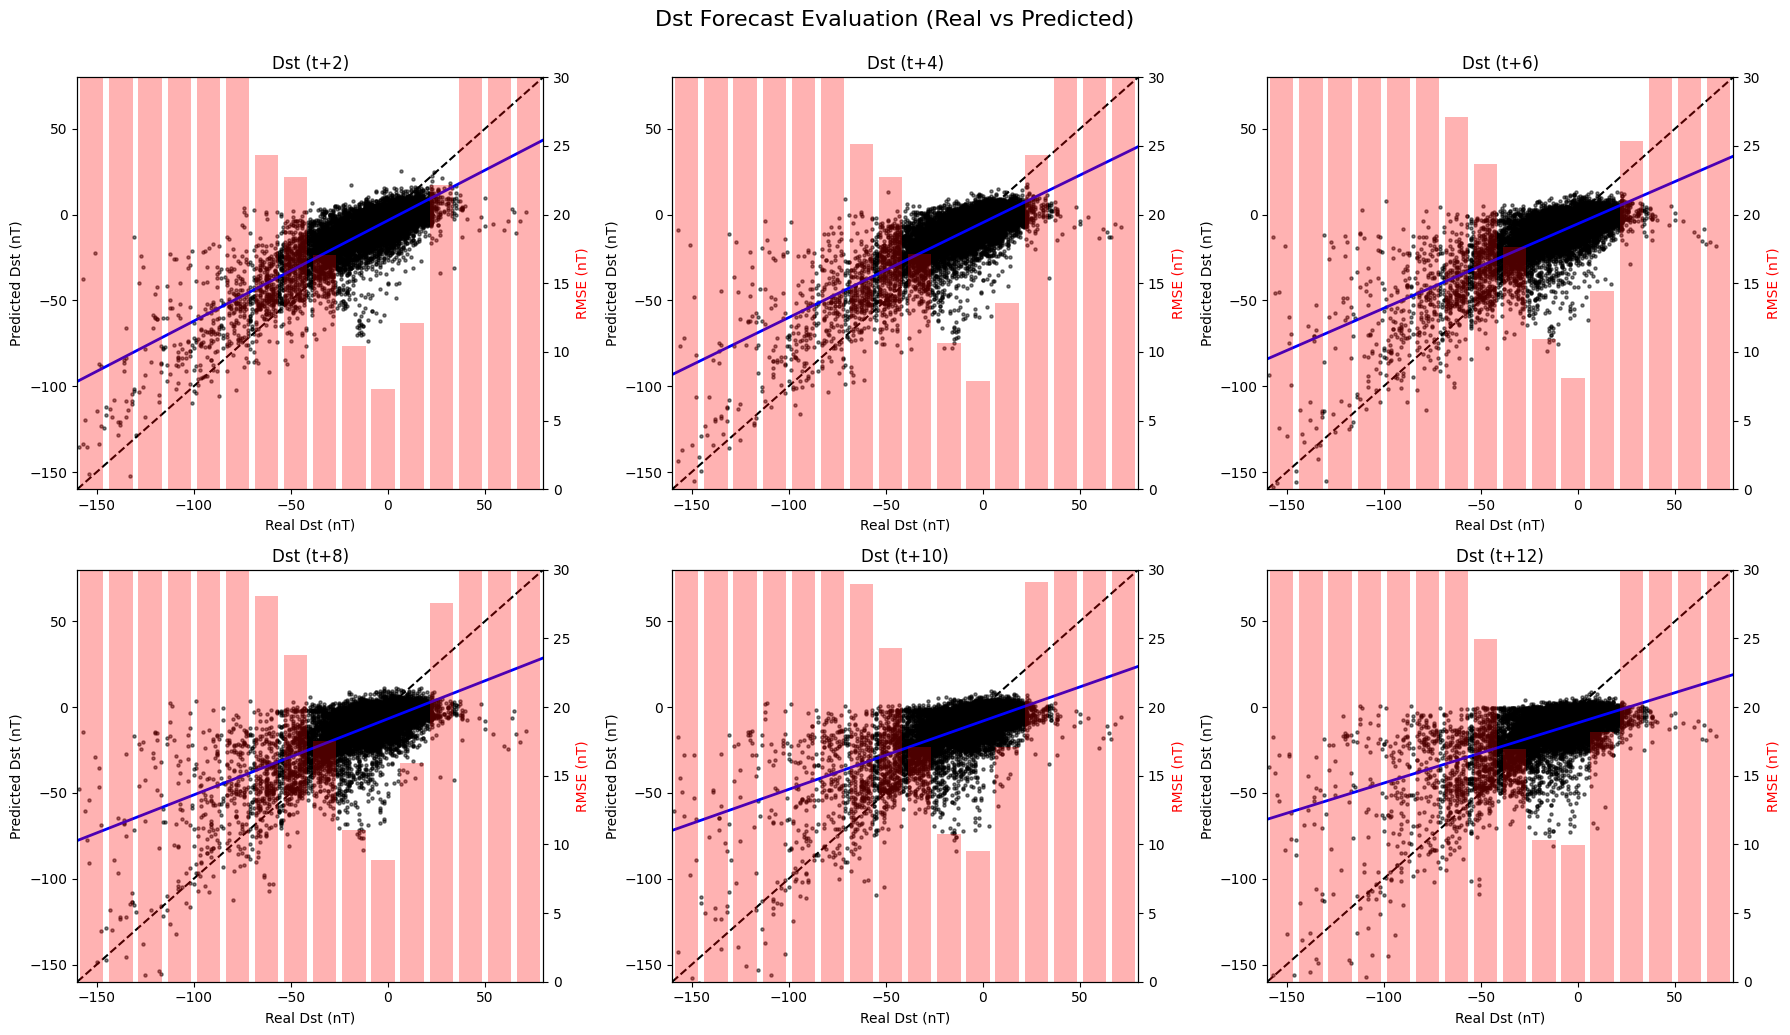

In [15]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ─────────── 1. CONFIG ───────────
CSV_PATH = "omni_dataset.csv"
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12
PARAMS = {'units': 64, 'batch_size': 32, 'epochs': 30, 'dropout': 0.2}

# ─────────── 2. LOAD DATA ───────────
df = pd.read_csv(CSV_PATH)[FEATURES + [TARGET]].dropna()
N = len(df)
print(f"Total rows: {N}")

N_train = int(0.80 * N)
N_val = int(0.10 * N)
N_test = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df = df.iloc[N_train:N_train + N_val]
test_df = df.iloc[N_train + N_val:]

# ─────────── 3. SCALING ───────────
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled = X_scaler.transform(val_df[FEATURES])
X_test_scaled = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled = y_scaler.transform(test_df[[TARGET]]).ravel()

# ─────────── 4. WINDOWING ───────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val, y_val = make_windows(X_val_scaled, y_val_scaled, LOOK_BACK, HORIZON)
X_test, y_test = make_windows(X_test_scaled, y_test_scaled, LOOK_BACK, HORIZON)

# ─────────── 5. BUILD & TRAIN MODEL ───────────
model = Sequential([
    Bidirectional(LSTM(PARAMS['units'])),
    Dropout(PARAMS['dropout']),
    Dense(HORIZON)
])
model.compile(optimizer=Adam(), loss='mse')

print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=PARAMS['epochs'],
    batch_size=PARAMS['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5,
                              restore_best_weights=True, verbose=0)],
    verbose=1
)

# ─────────── 6. INVERSE TRANSFORM ───────────
def inverse_scale(arr):
    return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

y_pred_test = inverse_scale(model.predict(X_test))
y_true_test = inverse_scale(y_test)

# ─────────── 7. PLOTTING ───────────
def plot_real_vs_predicted_DST(y_true, y_pred, horizons_to_plot=[1, 3, 5, 7, 9, 11]):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()

    for idx, h in enumerate(horizons_to_plot):
        ax = axs[idx]
        ax2 = ax.twinx()

        real_dst = y_true[:, h]
        pred_dst = y_pred[:, h]

        # Scatter plot
        ax.scatter(real_dst, pred_dst, color='black', alpha=0.5, s=5)
        ax.plot([-160, 80], [-160, 80], 'k--')  # Ideal line

        # Regression fit
        lr = LinearRegression().fit(real_dst.reshape(-1, 1), pred_dst)
        fit_line = lr.predict(np.array([[-160], [80]]))
        ax.plot([-160, 80], fit_line, color='blue', linewidth=2)

        ax.set_title(f'Dst (t+{h+1})')
        ax.set_xlim(-160, 80)
        ax.set_ylim(-160, 80)
        ax.set_xlabel("Real Dst (nT)")
        ax.set_ylabel("Predicted Dst (nT)")

        # RMSE per Dst bin
        bins = np.linspace(-160, 80, 17)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        rmse_per_bin = []
        for b0, b1 in zip(bins[:-1], bins[1:]):
            mask = (real_dst >= b0) & (real_dst < b1)
            if np.any(mask):
                rmse = np.sqrt(np.mean((real_dst[mask] - pred_dst[mask])**2))
            else:
                rmse = 0
            rmse_per_bin.append(rmse)

        ax2.bar(bin_centers, rmse_per_bin, width=12, alpha=0.3, color='red')
        ax2.set_ylabel("RMSE (nT)", color='red')
        ax2.set_ylim(0, 30)

    plt.tight_layout()
    plt.suptitle("Dst Forecast Evaluation (Real vs Predicted)", fontsize=16, y=1.03)
    plt.show()

# ─────────── 8. FINAL PLOT ───────────
plot_real_vs_predicted_DST(y_true_test, y_pred_test)


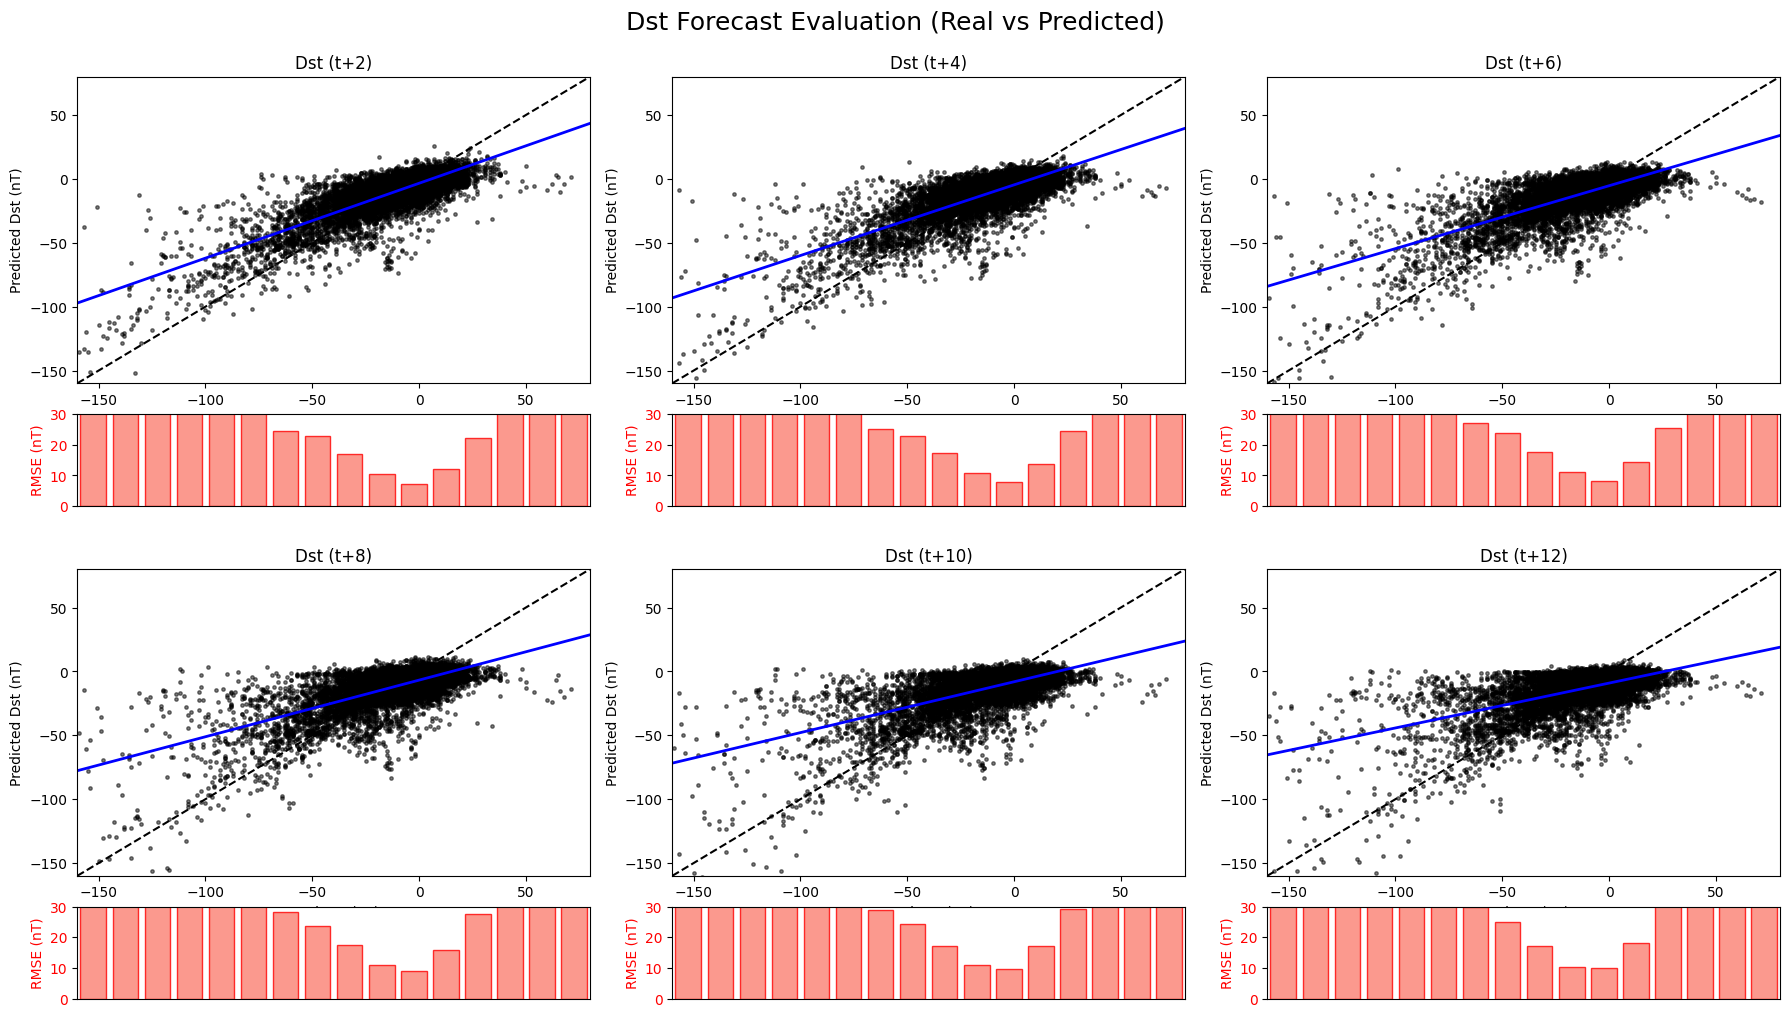

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_dst_like_paper(y_true, y_pred, steps=[1, 3, 5, 7, 9, 11]):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()

    for i, step in enumerate(steps):
        real_dst = y_true[:, step]
        pred_dst = y_pred[:, step]

        ax = axs[i]
        ax.scatter(real_dst, pred_dst, color='black', s=6, alpha=0.5)
        ax.plot([-160, 80], [-160, 80], 'k--', linewidth=1.5)  # Ideal 1:1 line

        # Regression line (blue)
        model = LinearRegression().fit(real_dst.reshape(-1, 1), pred_dst)
        fit_line = model.predict(np.array([[-160], [80]]))
        ax.plot([-160, 80], fit_line, color='blue', linewidth=2)

        # Axis setup
        ax.set_xlim(-160, 80)
        ax.set_ylim(-160, 80)
        ax.set_xlabel("Real Dst (nT)")
        ax.set_ylabel("Predicted Dst (nT)")
        ax.set_title(f"Dst (t+{step+1})")

        # RMSE histogram below scatter
        bins = np.linspace(-160, 80, 17)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        rmse_per_bin = []
        for b0, b1 in zip(bins[:-1], bins[1:]):
            mask = (real_dst >= b0) & (real_dst < b1)
            if np.any(mask):
                rmse = np.sqrt(np.mean((real_dst[mask] - pred_dst[mask]) ** 2))
            else:
                rmse = 0
            rmse_per_bin.append(rmse)

        # Histogram inset
        ax2 = ax.inset_axes([0, -0.4, 1, 0.3])  # inset axis below main
        ax2.bar(bin_centers, rmse_per_bin, width=12, color='salmon', edgecolor='red', alpha=0.8)
        ax2.set_xlim(-160, 80)
        ax2.set_ylim(0, 30)
        ax2.set_yticks([0, 10, 20, 30])
        ax2.set_ylabel("RMSE (nT)", color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticks([])
        ax2.set_xlabel("")  # Hide x-label for clean layout

    plt.tight_layout()
    plt.suptitle("Dst Forecast Evaluation (Real vs Predicted)", fontsize=18, y=1.03)
    plt.show()

# ─────────── 8. CALL THE PLOT FUNCTION ───────────
plot_dst_like_paper(y_true_test, y_pred_test)

# ###########################################################################################
# updated full code(moddel train + graph gen)
#############################################################################################
# import time
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam

# # ────────────── 1. CONFIG ──────────────
# CSV_PATH = "omni_dataset.csv"
# FEATURES = [
#     'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
#     'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
# ]
# TARGET = 'dst_index_nt'
# LOOK_BACK, HORIZON = 24, 12
# PARAMS = {'units': 64, 'batch_size': 32, 'epochs': 30, 'dropout': 0.2}

# # ────────────── 2. LOAD & SPLIT DATA ──────────────
# df = pd.read_csv(CSV_PATH)[FEATURES + [TARGET]].dropna()
# N = len(df)
# print(f"Total rows: {N}")

# N_train = int(0.80 * N)
# N_val = int(0.10 * N)
# N_test = N - N_train - N_val

# train_df = df.iloc[:N_train]
# val_df   = df.iloc[N_train:N_train + N_val]
# test_df  = df.iloc[N_train + N_val:]

# # ────────────── 3. SCALE FEATURES ──────────────
# X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

# X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
# X_val_scaled   = X_scaler.transform(val_df[FEATURES])
# X_test_scaled  = X_scaler.transform(test_df[FEATURES])

# y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
# y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
# y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# # ────────────── 4. CREATE WINDOWS ──────────────
# def make_windows(X, y, look_back=24, horizon=12):
#     Xs, ys = [], []
#     for i in range(len(X) - look_back - horizon + 1):
#         Xs.append(X[i:i+look_back])
#         ys.append(y[i+look_back:i+look_back+horizon])
#     return np.array(Xs), np.array(ys)

# X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
# X_val,   y_val   = make_windows(X_val_scaled,   y_val_scaled,   LOOK_BACK, HORIZON)
# X_test,  y_test  = make_windows(X_test_scaled,  y_test_scaled,  LOOK_BACK, HORIZON)

# # ────────────── 5. TRAIN BiLSTM MODEL ──────────────
# model = Sequential([
#     Bidirectional(LSTM(PARAMS['units'])),
#     Dropout(PARAMS['dropout']),
#     Dense(HORIZON)
# ])
# model.compile(optimizer=Adam(), loss='mse')

# print("\nTraining BiLSTM model...")
# model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=PARAMS['epochs'],
#     batch_size=PARAMS['batch_size'],
#     callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
#     verbose=1
# )

# # ────────────── 6. INVERSE SCALE PREDICTIONS ──────────────
# def inverse_scale(arr):
#     return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

# y_pred_test = inverse_scale(model.predict(X_test, verbose=0))
# y_true_test = inverse_scale(y_test)

# # ────────────── 7. PLOT GRAPH LIKE PAPER ──────────────
# def plot_dst_like_paper(y_true, y_pred, steps=[1, 3, 5, 7, 9, 11]):
#     fig, axs = plt.subplots(2, 3, figsize=(18, 10))
#     axs = axs.ravel()

#     for i, step in enumerate(steps):
#         real_dst = y_true[:, step]
#         pred_dst = y_pred[:, step]

#         ax = axs[i]
#         ax.scatter(real_dst, pred_dst, color='black', s=6, alpha=0.5)
#         ax.plot([-160, 80], [-160, 80], 'k--', linewidth=1.5)  # Ideal 1:1 line

#         # Linear regression fit
#         model = LinearRegression().fit(real_dst.reshape(-1, 1), pred_dst)
#         fit_line = model.predict(np.array([[-160], [80]]))
#         ax.plot([-160, 80], fit_line, color='blue', linewidth=2)

#         # Labels and limits
#         ax.set_xlim(-160, 80)
#         ax.set_ylim(-160, 80)
#         ax.set_xlabel("Real Dst (nT)")
#         ax.set_ylabel("Predicted Dst (nT)")
#         ax.set_title(f"Dst (t+{step+1})")

#         # Histogram RMSE in bins
#         bins = np.linspace(-160, 80, 17)
#         bin_centers = 0.5 * (bins[:-1] + bins[1:])
#         rmse_per_bin = []
#         for b0, b1 in zip(bins[:-1], bins[1:]):
#             mask = (real_dst >= b0) & (real_dst < b1)
#             if np.any(mask):
#                 rmse = np.sqrt(np.mean((real_dst[mask] - pred_dst[mask]) ** 2))
#             else:
#                 rmse = 0
#             rmse_per_bin.append(rmse)

#         # Add inset histogram below
#         ax2 = ax.inset_axes([0, -0.4, 1, 0.3])  # [x0, y0, width, height]
#         ax2.bar(bin_centers, rmse_per_bin, width=12, color='salmon', edgecolor='red', alpha=0.8)
#         ax2.set_xlim(-160, 80)
#         ax2.set_ylim(0, 30)
#         ax2.set_yticks([0, 10, 20, 30])
#         ax2.set_ylabel("RMSE (nT)", color='red')
#         ax2.tick_params(axis='y', labelcolor='red')
#         ax2.set_xticks([])
#         ax2.set_xlabel("")  # cleaner look

#     plt.tight_layout()
#     plt.suptitle("Dst Forecast Evaluation (Real vs Predicted)", fontsize=18, y=1.03)
#     plt.show()

# # ────────────── 8. CALL THE PLOT FUNCTION ──────────────
# plot_dst_like_paper(y_true_test, y_pred_test)



Graph 2

Epoch 1/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 76s 21ms/step - loss: 0.0230 - val_loss: 0.0018
Epoch 2/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 79s 21ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 4/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 8.3041e-04 - val_loss: 0.0011
Epoch 5/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 7.4961e-04 - val_loss: 0.0012
Epoch 6/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 7.9732e-04 - val_loss: 0.0010
Epoch 7/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - loss: 7.5000e-04 - val_loss: 0.0011
Epoch 8/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 7.1070e-04 - val_loss: 0.0012
Epoch 9/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - loss: 6.7779e-04 - val_loss: 0.0011
Epoch 10/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - loss: 6.7105e-04 - val_loss: 0.0010
Epoch 11/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - loss: 6.1225

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


KeyError: 0

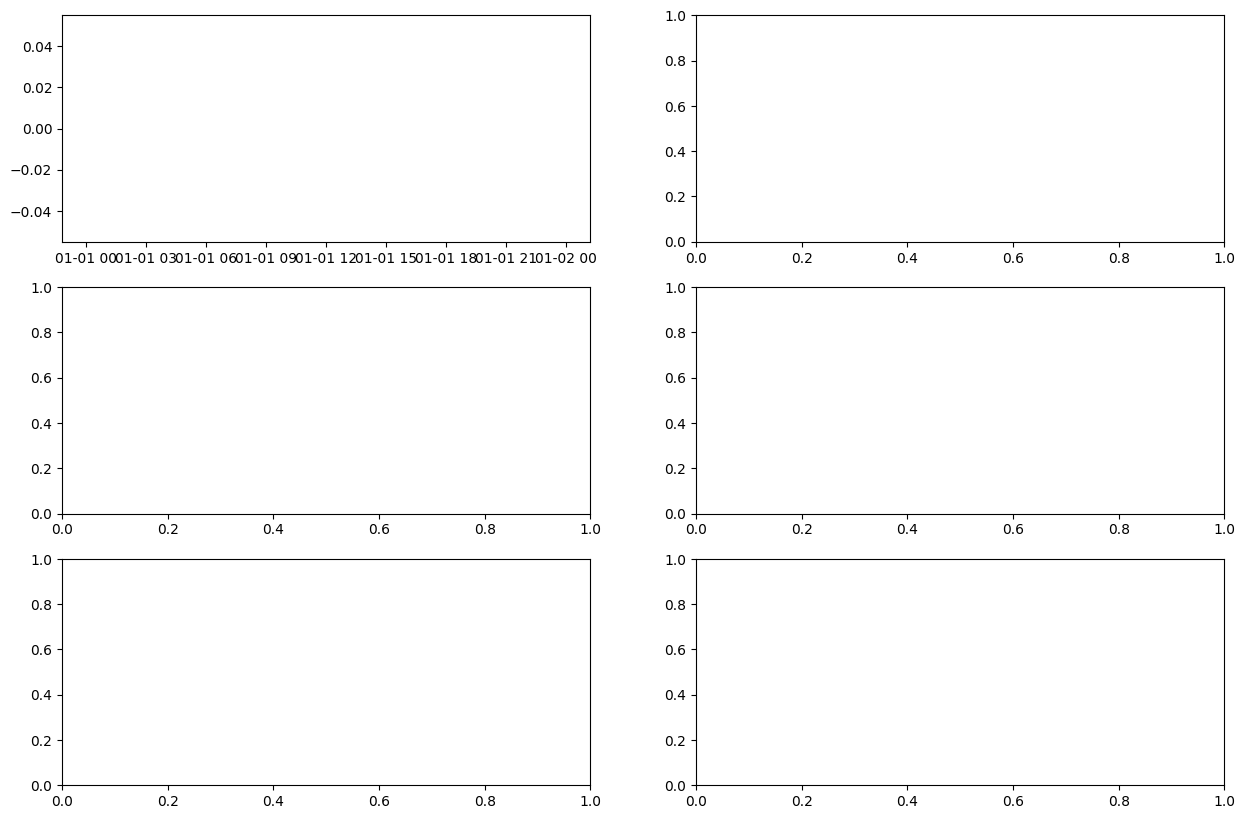

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ───────────── 1. Load and Prepare Data ─────────────
df = pd.read_csv("omni_dataset.csv")

# Build datetime index from year, doy, hour
df['datetime'] = pd.to_datetime(df['year'] * 1000 + df['doy'], format='%Y%j') + pd.to_timedelta(df['hour'], unit='h')
df = df.sort_values('datetime').reset_index(drop=True)

# Set target and features
TARGET = 'dst_index_nt'
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]

# Drop NaNs just in case
df = df[['datetime'] + FEATURES + [TARGET]].dropna().reset_index(drop=True)

# ───────────── 2. Scaling ─────────────
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_all = X_scaler.fit_transform(df[FEATURES])
y_all = y_scaler.fit_transform(df[[TARGET]]).ravel()

# ───────────── 3. Create Sequences ─────────────
LOOK_BACK, HORIZON = 24, 12
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X, y = make_windows(X_all, y_all, LOOK_BACK, HORIZON)
datetime_seq = df['datetime'][LOOK_BACK+HORIZON-1:].reset_index(drop=True)

# ───────────── 4. Train BiLSTM ─────────────
N = len(X)
train_end = int(N * 0.8)
val_end = int(N * 0.9)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
dt_test = datetime_seq[val_end:]

model = Sequential([
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(HORIZON)
])
model.compile(optimizer=Adam(), loss='mse')
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# ───────────── 5. Inverse Scale Predictions ─────────────
def inverse_scale(arr):
    return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

y_pred_test = inverse_scale(model.predict(X_test, verbose=0))
y_true_test = inverse_scale(y_test)

# ───────────── 6. Define Storm Periods ─────────────
# storm_periods = [
#     ("2015-06-22", "2015-06-27"),
#     ("2015-12-19", "2015-12-24"),
#     ("2016-03-06", "2016-03-11"),
#     ("2016-08-22", "2016-08-27"),
#     ("2017-09-06", "2017-09-11"),
#     ("2018-08-25", "2018-08-30")
# ]
# storm_periods = [
#     ("2022-03-17", "2022-03-21"),
#     ("2022-08-05", "2022-08-10"),
#     ("2023-01-25", "2023-01-30"),
#     ("2023-06-10", "2023-06-15"),
#     ("2024-02-14", "2024-02-20"),
#     ("2024-11-01", "2024-11-06")
# ]


# # ───────────── 7. Plot Storm Time Series ─────────────
# def plot_storm_event(start_date, end_date, time_index, y_true, y_pred, steps=[1, 5, 11], ax=None):
#     start = pd.to_datetime(start_date)
#     end = pd.to_datetime(end_date)
#     mask = (time_index >= start) & (time_index <= end)

#     t_range = time_index[mask]
#     true_dst = y_true[mask.values, 0]
#     ax.plot(t_range, true_dst, color='black', label='Real Dst', linewidth=1.5)

#     colors = ['blue', 'red', 'green']
#     labels = ['Dst t+2', 'Dst t+6', 'Dst t+12']
#     for idx, h in enumerate(steps):
#         pred = y_pred[mask.values, h]
#         ax.plot(t_range, pred, color=colors[idx], label=labels[idx])
#         R = np.corrcoef(true_dst, pred)[0,1]
#         ax.text(t_range[0], 30 - idx*12, f'R{labels[idx][-2:]}={R:.2f}', color=colors[idx])

#     ax.set_xlim(start, end)
#     ax.set_ylim(-160, 40)
#     ax.grid(True)
#     ax.legend()
#     ax.set_title(f"{start_date} to {end_date}")

# # ───────────── 8. Plot All Events ─────────────
# fig, axs = plt.subplots(3, 2, figsize=(15, 10))
# axs = axs.ravel()

# for i, (start, end) in enumerate(storm_periods):
#     plot_storm_event(start, end, dt_test, y_true_test, y_pred_test, ax=axs[i])

# plt.tight_layout()
# plt.suptitle("Dst Forecast During 6 Major Storm Events", fontsize=16, y=1.02)
# plt.show()
# in previous code model trained crctly but storm period is not there in test dataset. so i took updated vals of storm period which exists in test

storm_periods = [
    ("2024-02-14", "2024-02-20"),
    ("2024-04-05", "2024-04-10"),
    ("2024-06-18", "2024-06-23"),
    ("2024-08-01", "2024-08-06"),
    ("2024-10-12", "2024-10-17"),
    ("2024-11-01", "2024-11-06")
]



# ───────────── 7. Plot Storm Time Series ─────────────
def plot_storm_event(start_date, end_date, time_index, y_true, y_pred, steps=[1, 5, 11], ax=None):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    mask = (time_index >= start) & (time_index <= end)

    if not mask.any():
        print(f"⚠️ No data for {start_date} to {end_date}, skipping.")
        return

    t_range = time_index[mask].reset_index(drop=True)
    true_dst = y_true[mask.values, 0]

    ax.plot(t_range, true_dst, color='black', label='Real Dst', linewidth=1.5)

    colors = ['blue', 'red', 'green']
    labels = ['Dst t+2', 'Dst t+6', 'Dst t+12']
    for idx, h in enumerate(steps):
        pred = y_pred[mask.values, h]
        ax.plot(t_range, pred, color=colors[idx], label=labels[idx])
        R = np.corrcoef(true_dst, pred)[0,1]
        ax.text(t_range[0], 30 - idx*12, f'R{labels[idx][-2:]}={R:.2f}', color=colors[idx])

    ax.set_xlim(start, end)
    ax.set_ylim(-160, 40)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{start_date} to {end_date}")

# ───────────── 8. Plot All Events ─────────────
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()

for i, (start, end) in enumerate(storm_periods):
    plot_storm_event(start, end, dt_test, y_true_test, y_pred_test, ax=axs[i])

plt.tight_layout()
plt.suptitle("Dst Forecast During Major Storm Events and normal Events", fontsize=16, y=1.02)
plt.show()




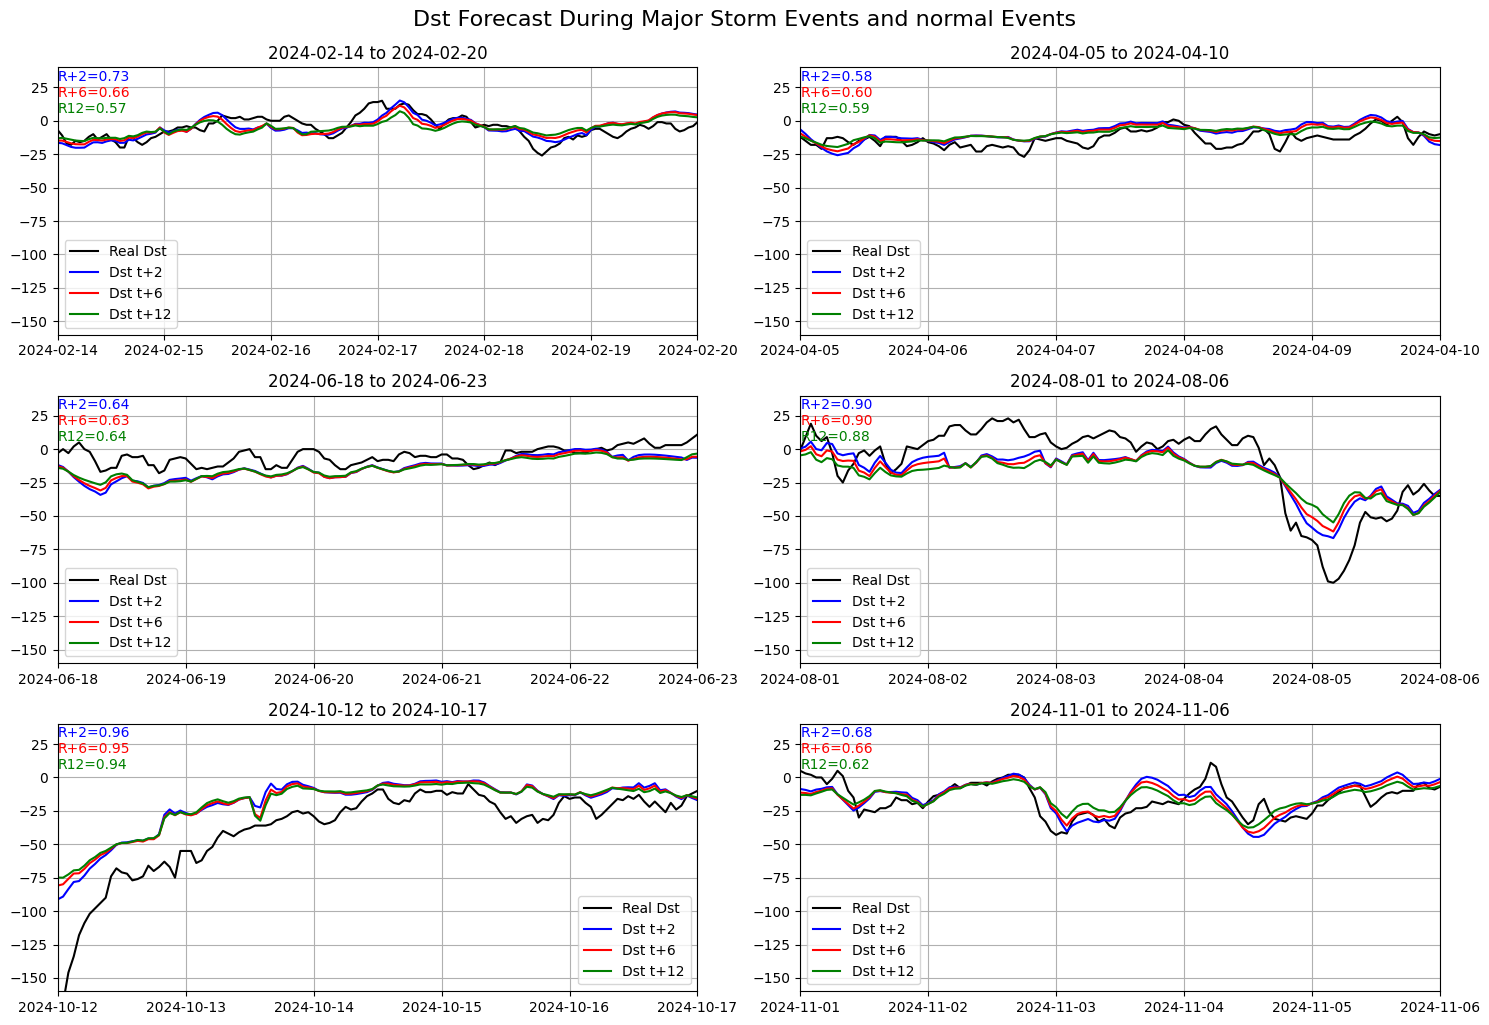

In [25]:
# in previous code model trained crctly but storm period is not there in test dataset. so i took updated vals of storm period which exists in test

storm_periods = [
    ("2024-02-14", "2024-02-20"),
    ("2024-04-05", "2024-04-10"),
    ("2024-06-18", "2024-06-23"),
    ("2024-08-01", "2024-08-06"),
    ("2024-10-12", "2024-10-17"),
    ("2024-11-01", "2024-11-06")
]



# ───────────── 7. Plot Storm Time Series ─────────────
def plot_storm_event(start_date, end_date, time_index, y_true, y_pred, steps=[1, 5, 11], ax=None):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    mask = (time_index >= start) & (time_index <= end)

    if not mask.any():
        print(f"⚠️ No data for {start_date} to {end_date}, skipping.")
        return

    t_range = time_index[mask].reset_index(drop=True)
    true_dst = y_true[mask.values, 0]

    ax.plot(t_range, true_dst, color='black', label='Real Dst', linewidth=1.5)

    colors = ['blue', 'red', 'green']
    labels = ['Dst t+2', 'Dst t+6', 'Dst t+12']
    for idx, h in enumerate(steps):
        pred = y_pred[mask.values, h]
        ax.plot(t_range, pred, color=colors[idx], label=labels[idx])
        R = np.corrcoef(true_dst, pred)[0,1]
        ax.text(t_range[0], 30 - idx*12, f'R{labels[idx][-2:]}={R:.2f}', color=colors[idx])

    ax.set_xlim(start, end)
    ax.set_ylim(-160, 40)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{start_date} to {end_date}")

# ───────────── 8. Plot All Events ─────────────
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()

for i, (start, end) in enumerate(storm_periods):
    plot_storm_event(start, end, dt_test, y_true_test, y_pred_test, ax=axs[i])

plt.tight_layout()
plt.suptitle("Dst Forecast During Major Storm Events and normal Events", fontsize=16, y=1.02)
plt.show()



Graph 3

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - loss: 0.0178 - val_loss: 7.1719e-04
Epoch 2/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0022 - val_loss: 6.4279e-04
Epoch 3/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.0017 - val_loss: 6.6945e-04
Epoch 4/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0015 - val_loss: 6.9334e-04
Epoch 5/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0014 - val_loss: 7.1895e-04
Epoch 6/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 0.0014 - val_loss: 6.2837e-04
Epoch 7/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0014 - val_loss: 6.1172e-04
Epoch 8/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0014 - val_loss: 6.4522e-04
Epoch 9/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.0013 - val_loss: 5.8239e-04
Epoch 10/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0014 - val_loss: 6.9143e-04
Epoch 11/30
4929/4929 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.001

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3834/3834 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 0.0198 - val_loss: 0.0022
Epoch 2/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - loss: 0.0025 - val_loss: 0.0112
Epoch 3/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 4/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 5/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 7/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 11/30
3834/3834 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/30
3834/3834 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2737/2737 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0172 - val_loss: 0.0052
Epoch 2/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 3/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 4/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 5/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 6/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 7/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0026 - val_loss: 0.0054
Epoch 8/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 9/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 10/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 11/30
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1642/1642 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0225 - val_loss: 0.0032
Epoch 2/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 3/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 4/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 7/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 9/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 11/30
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/30
1642/1642 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0392 - val_loss: 0.0119
Epoch 2/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0089 - val_loss: 0.0111
Epoch 3/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0068 - val_loss: 0.0095
Epoch 4/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 5/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0058 - val_loss: 0.0096
Epoch 6/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0052 - val_loss: 0.0104
Epoch 7/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0052 - val_loss: 0.0091
Epoch 8/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0047 - val_loss: 0.0090
Epoch 9/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0047 - val_loss: 0.0095
Epoch 10/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0047 - val_loss: 0.0091
Epoch 11/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0046 - val_loss: 0.0093
Epoch 12/30
546/546 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step

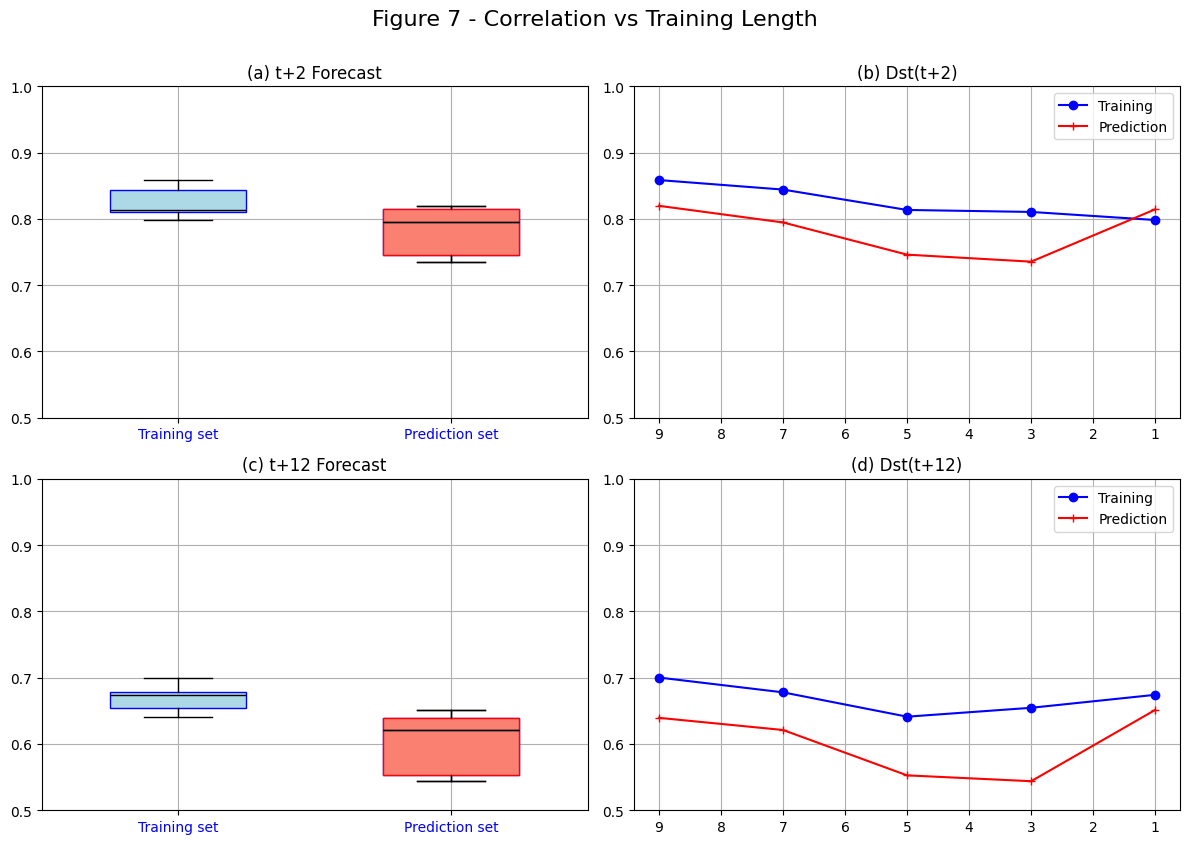

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ───────────── Load Data ─────────────
df = pd.read_csv("omni_dataset.csv")
df['datetime'] = pd.to_datetime(df['year'] * 1000 + df['doy'], format='%Y%j') + pd.to_timedelta(df['hour'], unit='h')
df = df.drop(columns=['year', 'doy', 'hour'], errors='ignore').dropna()
df = df.set_index('datetime')

FEATURES = ['sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt', 'sw_plasma_temp_k', 'sw_proton_density_n_cm3']
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12

# ───────────── Helper Functions ─────────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

def inverse_scale(arr, scaler):
    return arr * (scaler.data_max_[0] - scaler.data_min_[0]) + scaler.data_min_[0]

def compute_correlation(true_vals, pred_vals):
    return np.corrcoef(true_vals.ravel(), pred_vals.ravel())[0, 1]

# ───────────── Sliding Training Windows ─────────────
train_years = [9, 7, 5, 3, 1]
train_corrs_2, test_corrs_2 = [], []
train_corrs_12, test_corrs_12 = [], []
valid_years = []

for years in train_years:
    train_start = '2010-01-01'
    train_end = pd.Timestamp(train_start) + pd.DateOffset(years=years)
    val_start = train_end
    val_end = val_start + pd.DateOffset(years=1)
    test_start = val_end
    test_end = test_start + pd.DateOffset(years=1)

    train_df = df[train_start:train_end]
    val_df = df[val_start:val_end]
    test_df = df[test_start:test_end]

    if min(len(train_df), len(val_df), len(test_df)) < 1000:
        continue

    valid_years.append(years)

    # Scaling
    X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
    X_val_scaled = X_scaler.transform(val_df[FEATURES])
    X_test_scaled = X_scaler.transform(test_df[FEATURES])
    y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
    y_val_scaled = y_scaler.transform(val_df[[TARGET]]).ravel()
    y_test_scaled = y_scaler.transform(test_df[[TARGET]]).ravel()

    # Windowing
    X_train, y_train = make_windows(X_train_scaled, y_train_scaled)
    X_val, y_val = make_windows(X_val_scaled, y_val_scaled)
    X_test, y_test = make_windows(X_test_scaled, y_test_scaled)

    # CNN + LSTM model
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(LOOK_BACK, len(FEATURES))),
        LSTM(units=64),
        Dropout(0.2),
        Dense(HORIZON)
    ])
    model.compile(optimizer=Adam(), loss='mse')
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=16,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )

    # Predict & inverse scale
    y_train_pred = inverse_scale(model.predict(X_train, verbose=0), y_scaler)
    y_test_pred = inverse_scale(model.predict(X_test, verbose=0), y_scaler)
    y_train_true = inverse_scale(y_train, y_scaler)
    y_test_true = inverse_scale(y_test, y_scaler)

    # Correlation at t+2 and t+12
    train_corrs_2.append(compute_correlation(y_train_true[:, 1], y_train_pred[:, 1]))
    test_corrs_2.append(compute_correlation(y_test_true[:, 1], y_test_pred[:, 1]))
    train_corrs_12.append(compute_correlation(y_train_true[:, 11], y_train_pred[:, 11]))
    test_corrs_12.append(compute_correlation(y_test_true[:, 11], y_test_pred[:, 11]))

# ───────────── Plotting ─────────────
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Boxplots
axs[0, 0].boxplot([train_corrs_2, test_corrs_2], patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='black'),
                  positions=[1, 2], widths=0.5)
axs[0, 0].boxplot([test_corrs_2], patch_artist=True,
                  boxprops=dict(facecolor='salmon', color='red'), medianprops=dict(color='black'),
                  positions=[2], widths=0.5)
axs[0, 0].set_xticks([1, 2])
axs[0, 0].set_xticklabels(['Training set', 'Prediction set'], color='blue')
axs[0, 0].set_ylim(0.5, 1)
axs[0, 0].set_title("(a) t+2 Forecast")
axs[0, 0].grid(True)

axs[1, 0].boxplot([train_corrs_12, test_corrs_12], patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='black'),
                  positions=[1, 2], widths=0.5)
axs[1, 0].boxplot([test_corrs_12], patch_artist=True,
                  boxprops=dict(facecolor='salmon', color='red'), medianprops=dict(color='black'),
                  positions=[2], widths=0.5)
axs[1, 0].set_xticks([1, 2])
axs[1, 0].set_xticklabels(['Training set', 'Prediction set'], color='blue')
axs[1, 0].set_ylim(0.5, 1)
axs[1, 0].set_title("(c) t+12 Forecast")
axs[1, 0].grid(True)

# Line plots
axs[0, 1].plot(valid_years, train_corrs_2, 'o-', label='Training', color='blue')
axs[0, 1].plot(valid_years, test_corrs_2, '+-', label='Prediction', color='red')
axs[0, 1].set_ylim(0.5, 1)
axs[0, 1].invert_xaxis()
axs[0, 1].set_title("(b) Dst(t+2)")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 1].plot(valid_years, train_corrs_12, 'o-', label='Training', color='blue')
axs[1, 1].plot(valid_years, test_corrs_12, '+-', label='Prediction', color='red')
axs[1, 1].set_ylim(0.5, 1)
axs[1, 1].invert_xaxis()
axs[1, 1].set_title("(d) Dst(t+12)")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.suptitle("Figure 7 - Correlation vs Training Length", fontsize=16, y=1.05)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN + LSTM model...
Epoch 1/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - loss: 0.0225 - val_loss: 0.0031
Epoch 2/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 3/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 4/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 5/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 6/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 7/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 8/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 9/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - loss: 0.0012 - val_lo

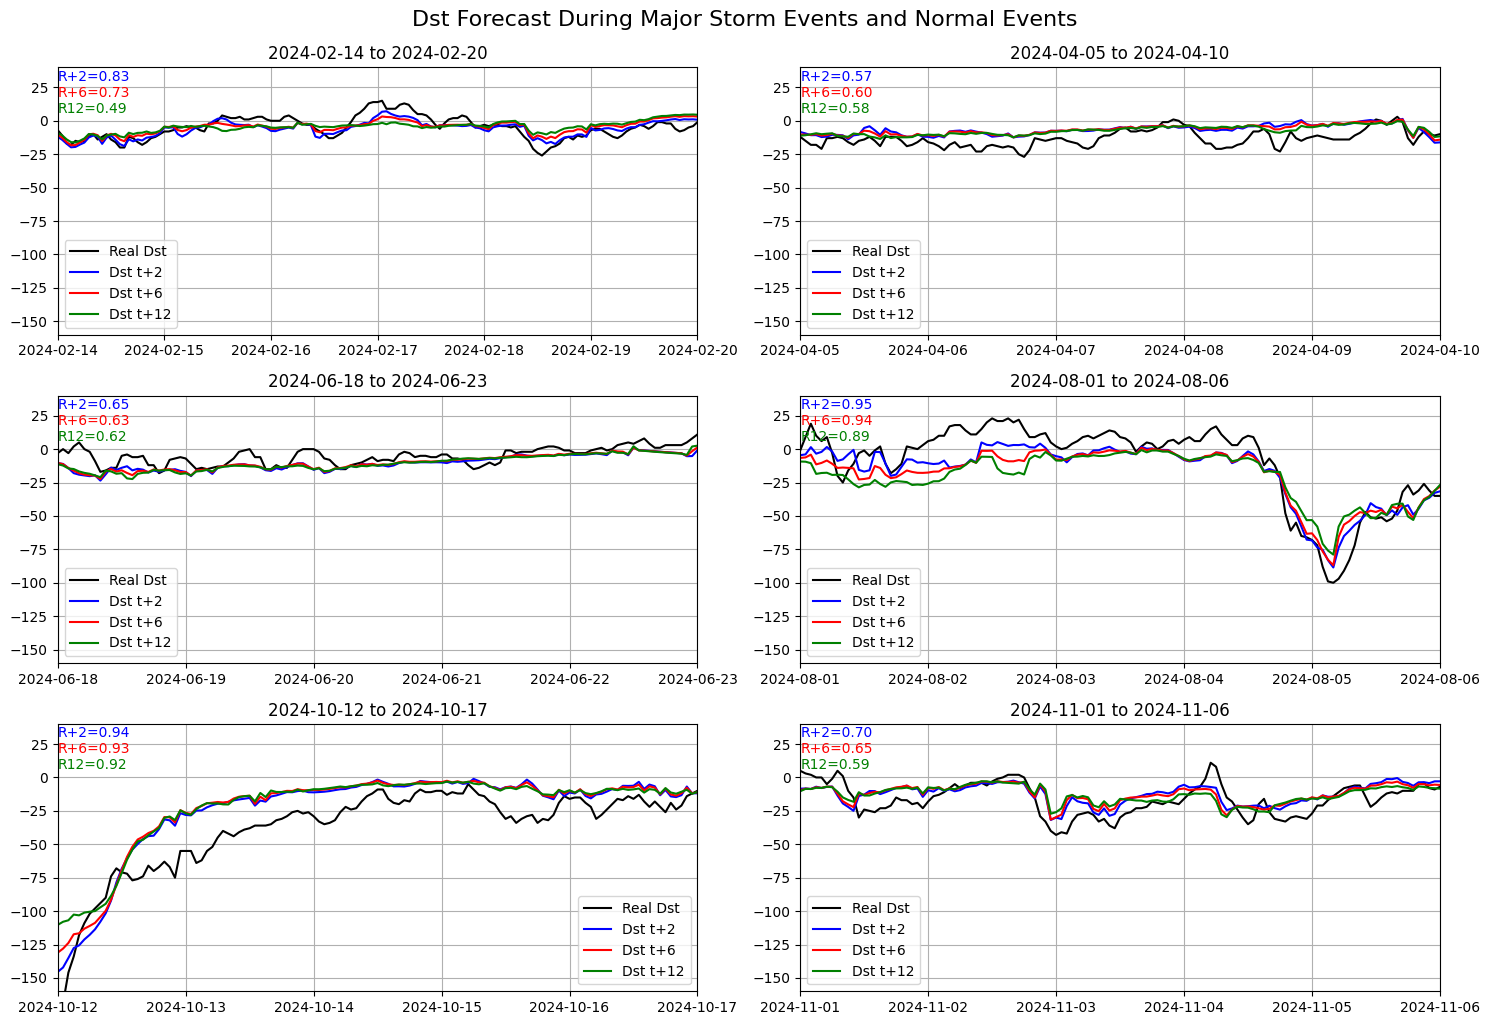

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ────────────── 1. CONFIG ──────────────
CSV_PATH = "omni_dataset.csv"
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12
PARAMS = {'filters': 64, 'kernel_size': 2, 'units': 64, 'dropout': 0.2, 'batch_size': 32, 'epochs': 30}

# ────────────── 2. LOAD DATA ──────────────
df = pd.read_csv(CSV_PATH)
df['datetime'] = pd.to_datetime(df['year'] * 1000 + df['doy'], format='%Y%j') + pd.to_timedelta(df['hour'], unit='h')
df = df.drop(columns=['year', 'doy', 'hour'], errors='ignore').dropna()
df = df.set_index('datetime')
df = df[FEATURES + [TARGET]]

# ────────────── 3. SPLIT DATA ──────────────
N = len(df)
N_train = int(0.80 * N)
N_val = int(0.10 * N)
N_test = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df   = df.iloc[N_train:N_train + N_val]
test_df  = df.iloc[N_train + N_val:]

# ────────────── 4. SCALING ──────────────
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled   = X_scaler.transform(val_df[FEATURES])
X_test_scaled  = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# ────────────── 5. MAKE WINDOWS ──────────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val,   y_val   = make_windows(X_val_scaled,   y_val_scaled,   LOOK_BACK, HORIZON)
X_test,  y_test  = make_windows(X_test_scaled,  y_test_scaled,  LOOK_BACK, HORIZON)

# ────────────── 6. TRAIN CNN + LSTM ──────────────
model = Sequential([
    Conv1D(filters=PARAMS['filters'], kernel_size=PARAMS['kernel_size'],
           activation='relu', input_shape=(LOOK_BACK, len(FEATURES))),
    LSTM(units=PARAMS['units']),
    Dropout(PARAMS['dropout']),
    Dense(HORIZON)
])
model.compile(optimizer=Adam(), loss='mse')

print("\nTraining CNN + LSTM model...")
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=PARAMS['epochs'],
    batch_size=PARAMS['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# ────────────── 7. INVERSE SCALE ──────────────
def inverse_scale(arr):
    return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

y_pred_test = inverse_scale(model.predict(X_test, verbose=0))
y_true_test = inverse_scale(y_test)

# Recover datetime range for test set
dt_full = df.index[LOOK_BACK + HORIZON - 1:].to_series().reset_index(drop=True)
dt_test = dt_full.iloc[-len(y_test):].reset_index(drop=True)

# ────────────── 8. STORM PERIODS ──────────────
storm_periods = [
    ("2024-02-14", "2024-02-20"),
    ("2024-04-05", "2024-04-10"),
    ("2024-06-18", "2024-06-23"),
    ("2024-08-01", "2024-08-06"),
    ("2024-10-12", "2024-10-17"),
    ("2024-11-01", "2024-11-06")
]

# ────────────── 9. STORM PLOT FUNCTION ──────────────
def plot_storm_event(start_date, end_date, time_index, y_true, y_pred, steps=[1, 5, 11], ax=None):
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    mask = (time_index >= start) & (time_index <= end)

    if not mask.any():
        print(f"⚠️ No data for {start_date} to {end_date}, skipping.")
        return

    t_range = time_index[mask].reset_index(drop=True)
    true_dst = y_true[mask.values, 0]

    ax.plot(t_range, true_dst, color='black', label='Real Dst', linewidth=1.5)

    colors = ['blue', 'red', 'green']
    labels = ['Dst t+2', 'Dst t+6', 'Dst t+12']
    for idx, h in enumerate(steps):
        pred = y_pred[mask.values, h]
        ax.plot(t_range, pred, color=colors[idx], label=labels[idx])
        R = np.corrcoef(true_dst, pred)[0,1]
        ax.text(t_range[0], 30 - idx*12, f'R{labels[idx][-2:]}={R:.2f}', color=colors[idx])

    ax.set_xlim(start, end)
    ax.set_ylim(-160, 40)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{start_date} to {end_date}")

# ────────────── 10. PLOT ALL EVENTS ──────────────
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs = axs.ravel()

for i, (start, end) in enumerate(storm_periods):
    plot_storm_event(start, end, dt_test, y_true_test, y_pred_test, ax=axs[i])

plt.tight_layout()
plt.suptitle("Dst Forecast During Major Storm Events and Normal Events", fontsize=16, y=1.02)
plt.show()


Total rows: 131736


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training CNN + LSTM model...
Epoch 1/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - loss: 0.0227 - val_loss: 0.0031
Epoch 2/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 4/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 6/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 8/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 80s 17ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 81s 17ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 11/30
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - loss: 0.00

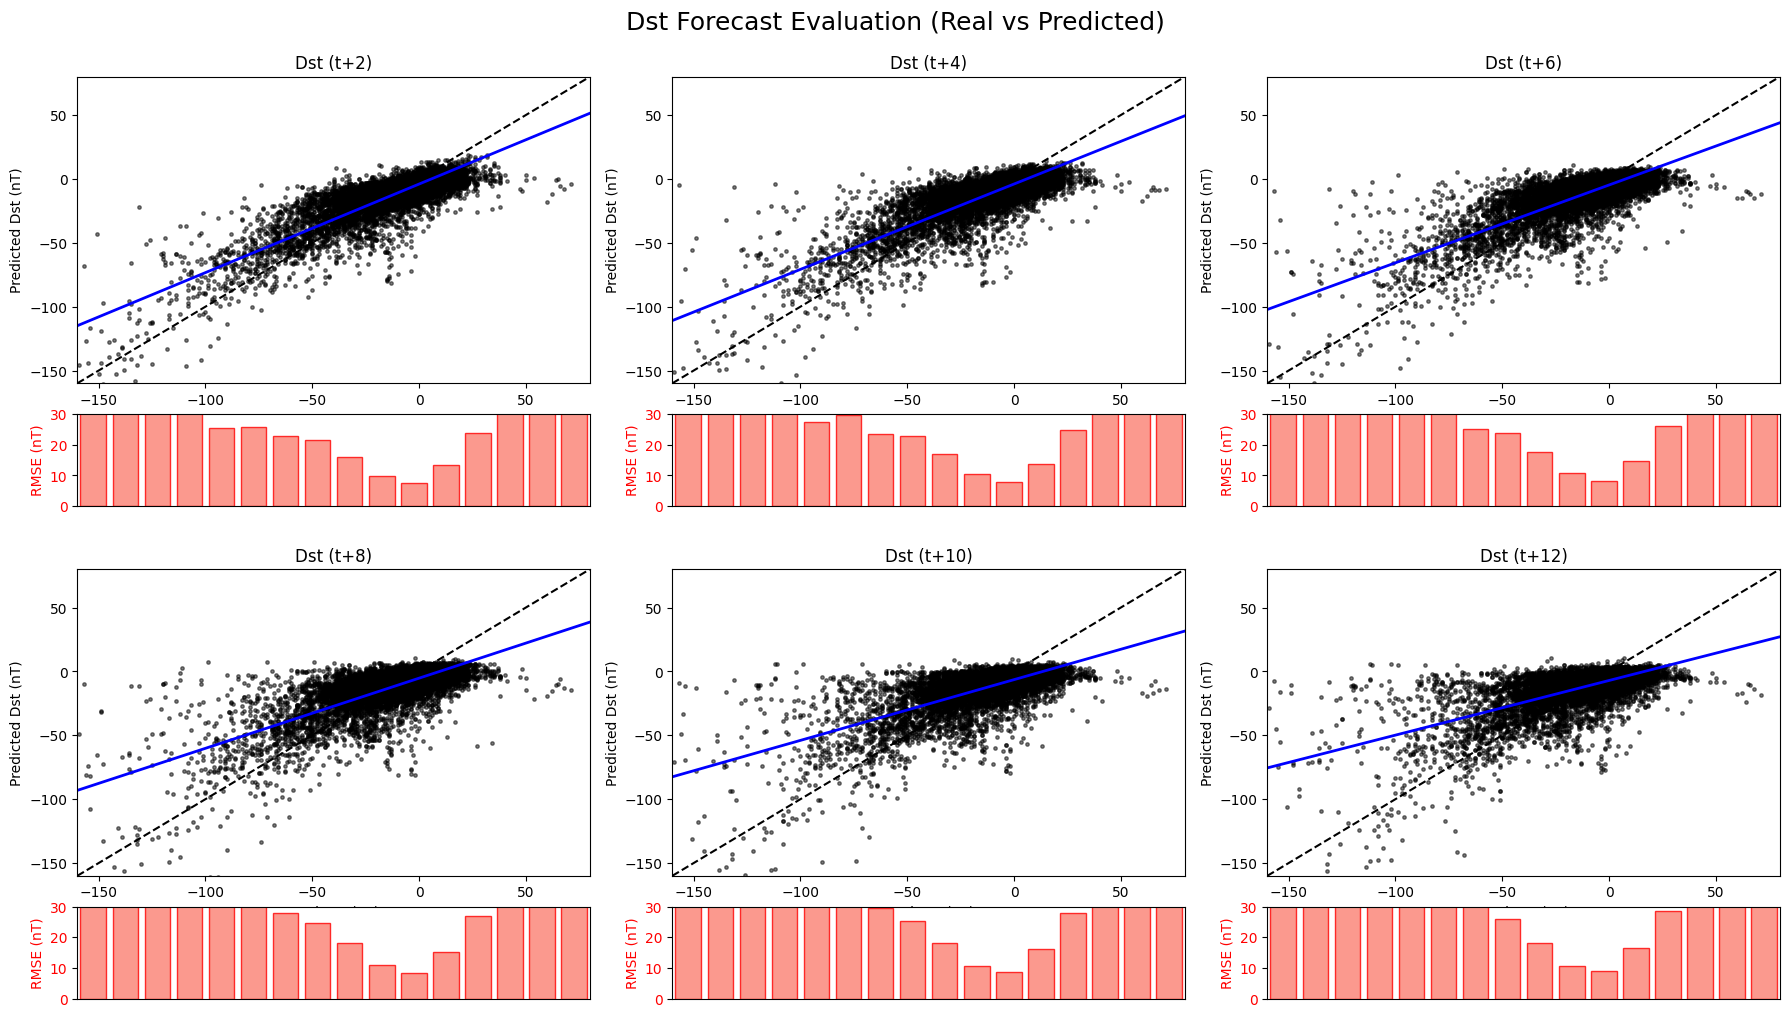

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ────────────── 1. CONFIG ──────────────
CSV_PATH = "omni_dataset.csv"
FEATURES = [
    'sw_plasma_speed_km_s', 'e_electric_field', 'bz_nt',
    'sw_plasma_temp_k', 'sw_proton_density_n_cm3'
]
TARGET = 'dst_index_nt'
LOOK_BACK, HORIZON = 24, 12
PARAMS = {'filters': 64, 'kernel_size': 2, 'units': 64, 'batch_size': 32, 'epochs': 30, 'dropout': 0.2}

# ────────────── 2. LOAD & SPLIT DATA ──────────────
df = pd.read_csv(CSV_PATH)[FEATURES + [TARGET]].dropna()
N = len(df)
print(f"Total rows: {N}")

N_train = int(0.80 * N)
N_val = int(0.10 * N)
N_test = N - N_train - N_val

train_df = df.iloc[:N_train]
val_df   = df.iloc[N_train:N_train + N_val]
test_df  = df.iloc[N_train + N_val:]

# ────────────── 3. SCALE FEATURES ──────────────
X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(train_df[FEATURES])
X_val_scaled   = X_scaler.transform(val_df[FEATURES])
X_test_scaled  = X_scaler.transform(test_df[FEATURES])

y_train_scaled = y_scaler.fit_transform(train_df[[TARGET]]).ravel()
y_val_scaled   = y_scaler.transform(val_df[[TARGET]]).ravel()
y_test_scaled  = y_scaler.transform(test_df[[TARGET]]).ravel()

# ────────────── 4. CREATE WINDOWS ──────────────
def make_windows(X, y, look_back=24, horizon=12):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i+look_back])
        ys.append(y[i+look_back:i+look_back+horizon])
    return np.array(Xs), np.array(ys)

X_train, y_train = make_windows(X_train_scaled, y_train_scaled, LOOK_BACK, HORIZON)
X_val,   y_val   = make_windows(X_val_scaled,   y_val_scaled,   LOOK_BACK, HORIZON)
X_test,  y_test  = make_windows(X_test_scaled,  y_test_scaled,  LOOK_BACK, HORIZON)

# ────────────── 5. TRAIN CNN + LSTM MODEL ──────────────
model = Sequential([
    Conv1D(filters=PARAMS['filters'], kernel_size=PARAMS['kernel_size'], activation='relu',
           input_shape=(LOOK_BACK, len(FEATURES))),
    LSTM(PARAMS['units']),
    Dropout(PARAMS['dropout']),
    Dense(HORIZON)
])
model.compile(optimizer=Adam(), loss='mse')

print("\nTraining CNN + LSTM model...")
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=PARAMS['epochs'],
    batch_size=PARAMS['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# ────────────── 6. INVERSE SCALE PREDICTIONS ──────────────
def inverse_scale(arr):
    return arr * (y_scaler.data_max_[0] - y_scaler.data_min_[0]) + y_scaler.data_min_[0]

y_pred_test = inverse_scale(model.predict(X_test, verbose=0))
y_true_test = inverse_scale(y_test)

# ────────────── 7. PLOT GRAPH LIKE PAPER ──────────────
def plot_dst_like_paper(y_true, y_pred, steps=[1, 3, 5, 7, 9, 11]):
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()

    for i, step in enumerate(steps):
        real_dst = y_true[:, step]
        pred_dst = y_pred[:, step]

        ax = axs[i]
        ax.scatter(real_dst, pred_dst, color='black', s=6, alpha=0.5)
        ax.plot([-160, 80], [-160, 80], 'k--', linewidth=1.5)  # Ideal 1:1 line

        # Linear regression fit
        model = LinearRegression().fit(real_dst.reshape(-1, 1), pred_dst)
        fit_line = model.predict(np.array([[-160], [80]]))
        ax.plot([-160, 80], fit_line, color='blue', linewidth=2)

        # Labels and limits
        ax.set_xlim(-160, 80)
        ax.set_ylim(-160, 80)
        ax.set_xlabel("Real Dst (nT)")
        ax.set_ylabel("Predicted Dst (nT)")
        ax.set_title(f"Dst (t+{step+1})")

        # Histogram RMSE in bins
        bins = np.linspace(-160, 80, 17)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        rmse_per_bin = []
        for b0, b1 in zip(bins[:-1], bins[1:]):
            mask = (real_dst >= b0) & (real_dst < b1)
            if np.any(mask):
                rmse = np.sqrt(np.mean((real_dst[mask] - pred_dst[mask]) ** 2))
            else:
                rmse = 0
            rmse_per_bin.append(rmse)

        # Add inset histogram below
        ax2 = ax.inset_axes([0, -0.4, 1, 0.3])  # [x0, y0, width, height]
        ax2.bar(bin_centers, rmse_per_bin, width=12, color='salmon', edgecolor='red', alpha=0.8)
        ax2.set_xlim(-160, 80)
        ax2.set_ylim(0, 30)
        ax2.set_yticks([0, 10, 20, 30])
        ax2.set_ylabel("RMSE (nT)", color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_xticks([])
        ax2.set_xlabel("")

    plt.tight_layout()
    plt.suptitle("Dst Forecast Evaluation (Real vs Predicted)", fontsize=18, y=1.03)
    plt.show()

# ────────────── 8. CALL THE PLOT FUNCTION ──────────────
plot_dst_like_paper(y_true_test, y_pred_test)


In [2]:
import pandas as pd
data = pd.read_csv('omni_dataset.csv')
print(data.isna().sum())

year                       0
doy                        0
hour                       0
scalar_b_nt                0
bx_nt                      0
by_nt                      0
bz_nt                      0
sw_plasma_temp_k           0
sw_proton_density_n_cm3    0
sw_plasma_speed_km_s       0
flow_pressure              0
e_electric_field           0
kp_index                   0
dst_index_nt               0
ap_index_nt                0
dtype: int64


In [5]:
import pandas as pd

# Load your dataset
df = pd.read_csv("omni_dataset.csv")

# Drop non-numeric or NaN-containing rows if needed
numeric_df = df.select_dtypes(include='number').dropna()

# Get summary statistics
summary = numeric_df.describe()

print(summary)


                year            doy           hour    scalar_b_nt  \
count  131736.000000  131736.000000  131736.000000  131736.000000   
mean     2017.015303     182.809984      11.500000      17.385106   
std         4.330227     105.619840       6.922213     107.872085   
min      2010.000000       1.000000       0.000000       0.500000   
25%      2013.000000      91.000000       5.750000       3.800000   
50%      2017.000000     183.000000      11.500000       4.900000   
75%      2021.000000     274.000000      17.250000       6.700000   
max      2025.000000     366.000000      23.000000     999.900000   

               bx_nt          by_nt          bz_nt  sw_plasma_temp_k  \
count  131736.000000  131736.000000  131736.000000      1.317360e+05   
mean       11.893778      11.851491      11.875958      1.479664e+05   
std       108.485336     108.505627     108.475097      7.880554e+05   
min       -23.000000     -33.200000     -46.500000      3.299000e+03   
25%        -2.4000